In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Loading Data
df_train = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
df_test = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")

print(df_train.shape , df_test.shape)

df_train

NameError: name 'pd' is not defined

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


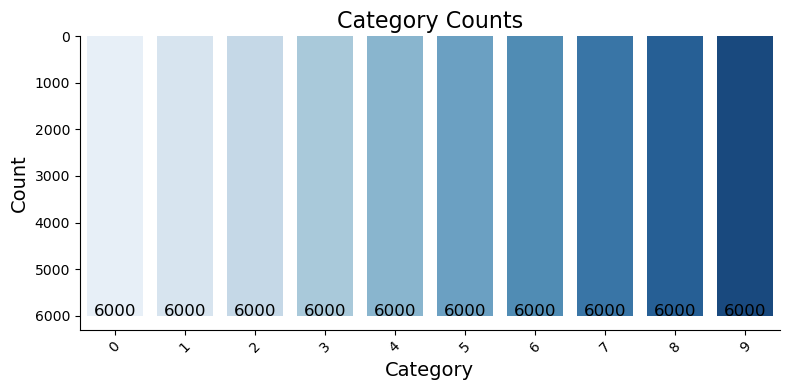

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 

# Count occurrences of each category
category_counts = df_train['label'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Set a custom color palette for the bars (optional)
custom_palette = sns.color_palette("Blues", len(category_counts))

# Create bar chart
plt.figure(figsize=(8, 4))  
ax = sns.barplot(x='Category', y='Count', data=category_counts, palette=custom_palette)

# Add count labels above bars with a nice font size and color
for i, count in enumerate(category_counts['Count']):
    ax.text(i, count + 10, s=f"{count}", ha='center', fontsize=12, color='black')

# Set titles and axis labels with a larger font size
plt.title('Category Counts', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Set y-axis order
ax.invert_yaxis()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Remove the top and right spines
sns.despine()

# Display plot
plt.tight_layout()
plt.show()

In [4]:
# Reshape the pixel values into 28x28 arrays
image_train = df_train.iloc[:, 1:785].values.reshape(-1 ,28, 28) / 255.0
image_test = df_test.iloc[:, 1:785].values.reshape(-1 ,28, 28) / 255.0

y_train = df_train.iloc[:, 0:1].values.reshape(-1, 1)
y_test  = df_test.iloc[:, 0:1].values.reshape(-1, 1)

print(image_train.shape , " || ",y_train.shape)

(60000, 28, 28)  ||  (60000, 1)


In [5]:
import torch
import torch.nn as nn

In [6]:
inputs_train   = torch.from_numpy(image_train.astype(np.float32))
inputs_test    = torch.from_numpy(image_test.astype(np.float32))

y_train_torch  = torch.from_numpy(y_train.astype(np.int32))
y_test_torch   = torch.from_numpy(y_test.astype(np.int32))

In [7]:
# Define LSTM Model

class LSTM(nn.Module):
    def __init__(self , input_size , hidden_size  , output_size):
        super(LSTM , self).__init__()
        self.input = input_size
        self.output = output_size
        self.H = hidden_size
        
        self.LSTM = nn.LSTM(input_size = self.input , hidden_size  = self.H)
        
        self.fc   = nn.Linear(self.H , self.output)
        
    def forward(self, x):
        x, _ = self.LSTM(x)
        x = self.fc(x[:, -1, :])
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [9]:
hidden_size = 256
input_size = 28
output_size = 10

model = LSTM(input_size = input_size , hidden_size= hidden_size,
 output_size = output_size).to(device)


optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

print(model)

LSTM(
  (LSTM): LSTM(28, 256)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)


In [10]:
from torch.utils.data import TensorDataset, DataLoader

# Define batch size
batch_size = 64

# Define data loaders for training and testing data in batches
train_data = TensorDataset(inputs_train, y_train_torch)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

test_data = TensorDataset(inputs_test, y_test_torch)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [11]:
num_epochs = 50

train_losses = []  # To store train losses
test_losses = []   # To store test losses

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        inputs = inputs.reshape(-1, 28, 28).to(device)
        targets = targets.reshape(-1, 1).to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        targets = targets.view(-1).long()
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Accumulate train loss
        train_loss += loss.item()

    # Calculate and store the average train loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    
    # Validation (testing) after each epoch
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.reshape(-1, 28, 28).to(device)
            targets = targets.reshape(-1, 1).to(device)

            # Forward pass
            outputs = model(inputs)
            targets = targets.view(-1).long()
            loss = criterion(outputs, targets)

            # Accumulate test loss
            test_loss += loss.item()

    # Calculate and store the average test loss for this epoch
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    # Print loss
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")

Epoch 1/50 - Train Loss: 1507.3331 - Test Loss: 226.6344
Epoch 2/50 - Train Loss: 1328.7148 - Test Loss: 217.9739
Epoch 3/50 - Train Loss: 1289.1385 - Test Loss: 212.7601
Epoch 4/50 - Train Loss: 1268.6913 - Test Loss: 210.2073
Epoch 5/50 - Train Loss: 1253.9405 - Test Loss: 208.3605
Epoch 6/50 - Train Loss: 1242.9887 - Test Loss: 206.5270
Epoch 7/50 - Train Loss: 1232.4217 - Test Loss: 204.7428
Epoch 8/50 - Train Loss: 1223.9463 - Test Loss: 203.5571
Epoch 9/50 - Train Loss: 1217.0733 - Test Loss: 202.4779
Epoch 10/50 - Train Loss: 1209.4443 - Test Loss: 201.7611
Epoch 11/50 - Train Loss: 1204.8443 - Test Loss: 200.9964
Epoch 12/50 - Train Loss: 1199.9818 - Test Loss: 200.3561
Epoch 13/50 - Train Loss: 1196.0801 - Test Loss: 200.1009
Epoch 14/50 - Train Loss: 1192.3532 - Test Loss: 199.7758
Epoch 15/50 - Train Loss: 1188.2149 - Test Loss: 199.3302
Epoch 16/50 - Train Loss: 1185.4480 - Test Loss: 198.4961
Epoch 17/50 - Train Loss: 1182.8931 - Test Loss: 198.1982
Epoch 18/50 - Train Los

In [12]:
with torch.no_grad():
    predicted_values = np.argmax(model(inputs_test.reshape(-1, 28, 28).to(device)).cpu().numpy() , axis=1)

In [14]:
from sklearn.metrics import accuracy_score, f1_score

# compute accuracy and F1 score
accuracy = accuracy_score(y_test, predicted_values)
f1 = f1_score(y_test, predicted_values, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.4976
F1 Score: 0.4860


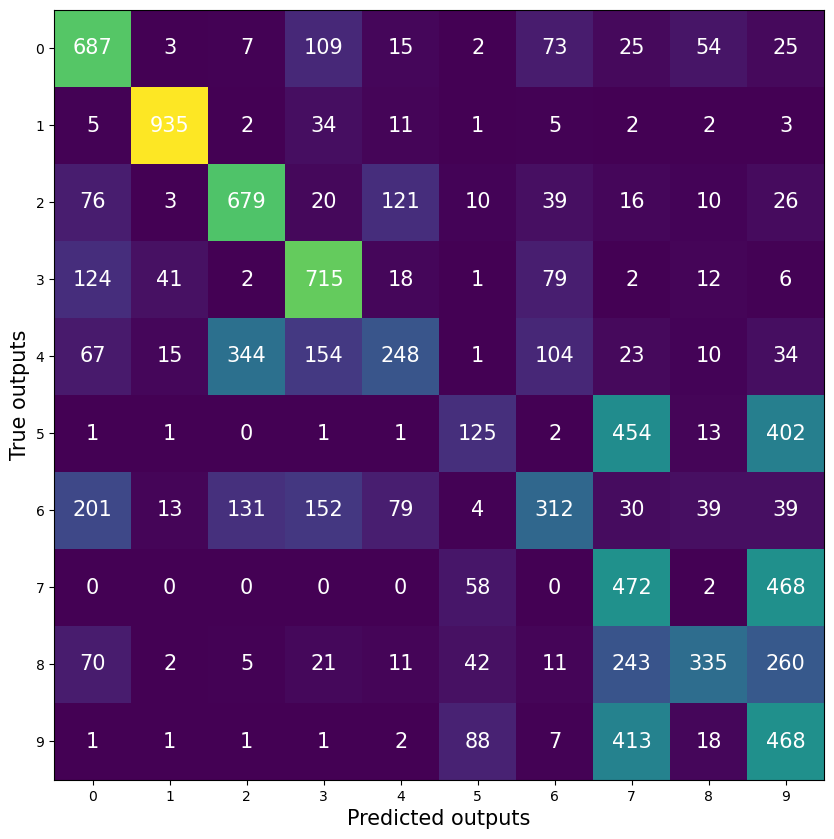

In [15]:
from sklearn.metrics import confusion_matrix
num_classes = 10
# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_values)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=15, color='black')
ax.set_ylabel('True outputs', fontsize=15, color='black')
ax.xaxis.set(ticks=range(num_classes))
ax.yaxis.set(ticks=range(num_classes))

for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=15)
plt.show()